In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy.stats import t
from scipy.stats import norm
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing 

In [2]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y


In [3]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(0, len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, deg=1)

    return bs_slope_reps, bs_intercept_reps

In [4]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [5]:
draft_df = pd.read_csv('careers_df.csv')

In [6]:
draft_df.columns

Index(['Year', 'Name', 'College', 'POS', 'Height (in)', 'Weight (lbs)',
       '40 Yard', 'Bench Press', 'Vert Leap (in)', 'Broad Jump (in)',
       'Shuttle', '3Cone', 'Win-Loss Record', 'Round', 'Pick', 'Team', 'Age',
       'To', 'AP1', 'PB', 'St', 'CarAV', 'DrAV', 'Solo', 'Int', 'Sacks',
       'Drafted'],
      dtype='object')

In [7]:
draft_df.head()

,Year,Name,College,POS,Height (in),Weight (lbs),40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),...,To,AP1,PB,St,CarAV,DrAV,Solo,Int,Sacks,Drafted
0,2000.0,Rashard Anderson,Jackson State (MS),CB,74.4,206.0,4.59,NaN,34.0,123.0,...,2001.0,0.0,0.0,1.0,7.0,7.0,68.0,1.0,NaN,D
1,2000.0,Corey Atkins,South Carolina,OLB,72.4,237.0,4.76,21.0,31.0,112.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U
2,2000.0,Reggie Austin,Wake Forest,CB,69.4,175.0,4.46,17.0,35.0,119.0,...,2002.0,0.0,0.0,0.0,2.0,2.0,18.0,2.0,NaN,D
3,2000.0,Rashidi Barnes,Colorado,FS,71.6,208.0,4.63,10.0,35.0,114.0,...,2000.0,0.0,0.0,0.0,1.0,1.0,15.0,NaN,NaN,D
4,2000.0,David Barrett,Arkansas,CB,69.9,199.0,4.48,16.0,37.5,116.0,...,2008.0,0.0,0.0,6.0,31.0,14.0,391.0,18.0,0.5,D


In [8]:
draft_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1633 entries, 0 to 1632
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             1633 non-null   float64
 1   Name             1633 non-null   object 
 2   College          1632 non-null   object 
 3   POS              1633 non-null   object 
 4   Height (in)      1633 non-null   float64
 5   Weight (lbs)     1633 non-null   float64
 6   40 Yard          1409 non-null   float64
 7   Bench Press      1225 non-null   float64
 8   Vert Leap (in)   1237 non-null   float64
 9   Broad Jump (in)  1235 non-null   float64
 10  Shuttle          1038 non-null   float64
 11  3Cone            1030 non-null   float64
 12  Win-Loss Record  1460 non-null   object 
 13  Round            1122 non-null   float64
 14  Pick             1122 non-null   float64
 15  Team             1122 non-null   object 
 16  Age              1060 non-null   float64
 17  To            

In [9]:
drafted= draft_df[draft_df['Drafted'] == 'D']
undrafted = draft_df[draft_df['Drafted'] == 'U']


# Exploring Bench Press

In [10]:
draft_df.groupby(by='Drafted')['Bench Press'].describe()

,count,mean,std,min,25%,50%,75%,max
Drafted,,,,,,,,
D,853.0,21.378664,6.703539,2.0,16.0,21.0,26.0,45.0
U,372.0,19.983871,6.353873,5.0,15.0,20.0,24.0,45.0


In [11]:
bench_mean = round(np.mean(draft_df['Bench Press']), 3)
bench_std= round(np.std(draft_df['Bench Press']), 3)
bench_mean, bench_std

(20.955, 6.625)

C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


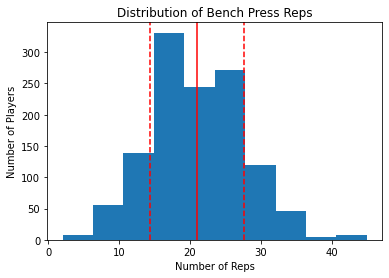

In [12]:
_ = plt.hist(draft_df['Bench Press'])
_ = plt.xlabel('Number of Reps')
_ = plt.ylabel('Number of Players')
_ = plt.title('Distribution of Bench Press Reps')
_ = plt.axvline(bench_mean, color='r')
_ = plt.axvline(bench_mean + bench_std, color='r', linestyle='--')
_ = plt.axvline(bench_mean - bench_std, color='r', linestyle='--')

In [13]:
bench_draft = drafted['Bench Press']
bench_udraft = undrafted['Bench Press']


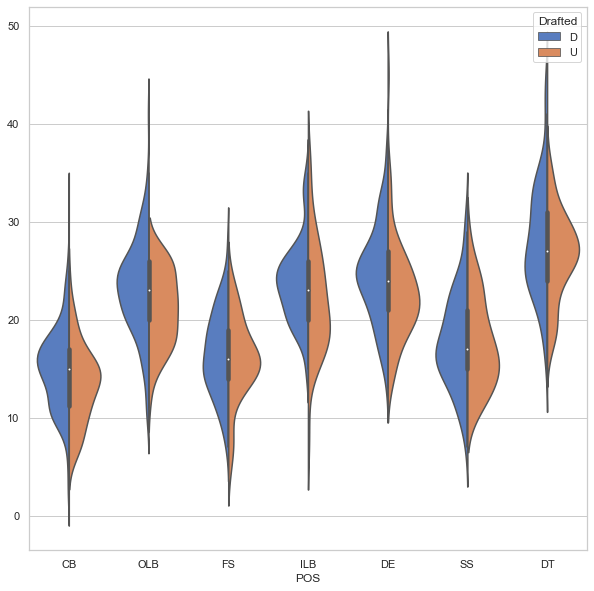

In [14]:
sns.set_theme(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
plt.figure(figsize=(10,10))
ax = sns.violinplot(data=draft_df, x="POS", y="Bench Press", hue="Drafted", split=True)
_ = ax.set(ylabel="")

# Exploring 40 Yard Dash

In [15]:
draft_df.groupby(by='Drafted')['40 Yard'].describe()

,count,mean,std,min,25%,50%,75%,max
Drafted,,,,,,,,
D,984.0,4.713211,0.236095,4.30,4.53,4.65,4.86,5.71
U,425.0,4.798988,0.228490,4.36,4.62,4.75,4.97,5.54


In [16]:
yard40_mean = round(np.mean(draft_df['40 Yard']), 3)
yard40_std = round(np.std(draft_df['40 Yard']), 3)
yard40_mean, yard40_std

(4.739, 0.237)

C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


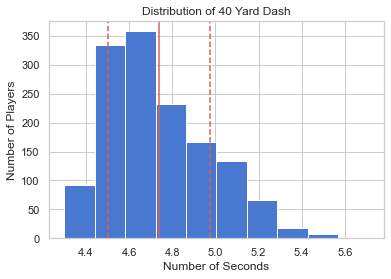

In [17]:
_ = plt.hist(draft_df['40 Yard'])
_ = plt.xlabel('Number of Seconds')
_ = plt.ylabel('Number of Players')
_ = plt.title('Distribution of 40 Yard Dash')
_ = plt.axvline(yard40_mean, color='r')
_ = plt.axvline(yard40_mean + yard40_std, color='r', linestyle='--')
_ = plt.axvline(yard40_mean - yard40_std, color='r', linestyle='--')

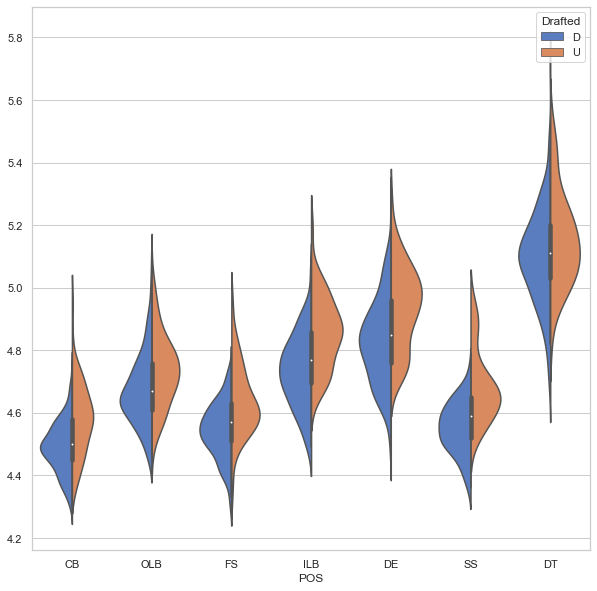

In [18]:
sns.set_theme(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
plt.figure(figsize=(10,10))
ax = sns.violinplot(data=draft_df, x="POS", y="40 Yard", hue="Drafted", split=True)
_ = ax.set(ylabel="")

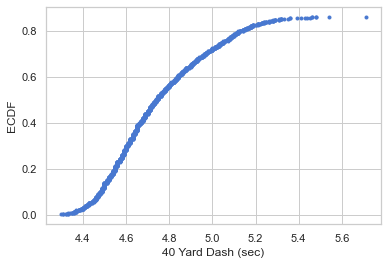

In [19]:
x_yard, y_yard = ecdf(draft_df['40 Yard'])

_ = plt.plot(x_yard, y_yard, marker='.', linestyle='none')

_ = plt.xlabel('40 Yard Dash (sec)')
_ = plt.ylabel('ECDF')

In [20]:
yard_draft = drafted['40 Yard']
yard_udraft = undrafted['40 Yard']
np.mean(yard_draft), np.mean(yard_udraft)

(4.713211382113826, 4.798988235294118)

In [21]:
for i in range(len(draft_df)):
    if draft_df.iloc[i, 26] == 'D' and np.isnan(draft_df.iloc[i, 6]):
        draft_df.iloc[i, 6] = np.mean(drafted['40 Yard'])
    elif draft_df.iloc[i, 26] == 'U' and np.isnan(draft_df.iloc[i, 6]):
        draft_df.iloc[i, 6] = np.mean(undrafted['40 Yard'])


In [22]:
#draft_df['Permutation40'] = np.random.permutation(draft_df['40 Yard'])

#draft_df.groupby(by='Drafted')['Permutation40'].describe()

In [23]:
diff40 = []

for i in range(10000):
    perm = np.random.permutation(draft_df['40 Yard'])
    mean_diff = np.mean(perm[draft_df['Drafted'] == 'D']) - np.mean(perm[draft_df['Drafted'] == 'U'])
    diff40.append(mean_diff)

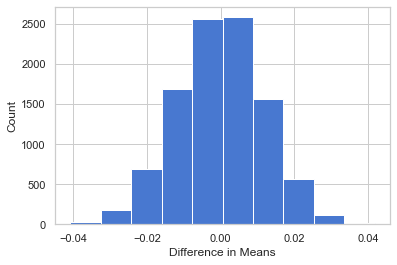

In [24]:
_ = plt.hist(diff40)
_ = plt.xlabel('Difference in Means')
_ = plt.ylabel('Count')

In [25]:
yard40_obs = np.mean(yard_draft) - np.mean(yard_udraft)
yard40_obs = abs(yard40_obs)
print(yard40_obs)

0.08577685318029182


In [26]:
pos_extreme = []
neg_extreme = []

for j in range(len(diff40)):
    if(diff40[j] >= yard40_obs):
        pos_extreme.append(diff40[j])
    elif(diff40[j] <= -yard40_obs):
        neg_extreme.append(diff40[j])
print(len(pos_extreme))
print(len(neg_extreme))

0
0


Lower than 5% reject null hypothesis

# Exploring Vertical Leap

In [27]:
draft_df.groupby(by='Drafted')['Vert Leap (in)'].describe()

,count,mean,std,min,25%,50%,75%,max
Drafted,,,,,,,,
D,864.0,34.439815,3.818882,20.5,32.0,34.5,37.0,46.0
U,373.0,33.343164,3.831840,21.5,31.0,33.5,36.0,45.5


In [28]:
vert_leap_mean = round(np.mean(draft_df['Vert Leap (in)']), 3)
vert_leap_std = round(np.std(draft_df['Vert Leap (in)']), 3)
vert_leap_mean, vert_leap_std

(34.109, 3.853)

C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


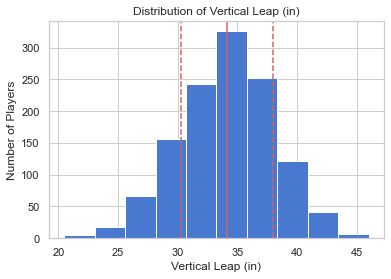

In [29]:
_ = plt.hist(draft_df['Vert Leap (in)'])
_ = plt.xlabel('Vertical Leap (in)')
_ = plt.ylabel('Number of Players')
_ = plt.title('Distribution of Vertical Leap (in)')

_ = plt.axvline(vert_leap_mean, color='r')
_ = plt.axvline(vert_leap_mean + vert_leap_std, color='r', linestyle='--')
_ = plt.axvline(vert_leap_mean - vert_leap_std, color='r', linestyle='--')

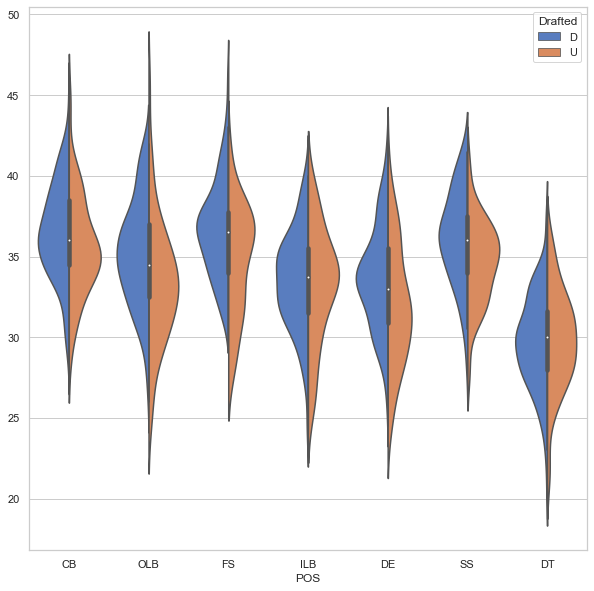

In [30]:
sns.set_theme(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
plt.figure(figsize=(10,10))
ax = sns.violinplot(data=draft_df, x="POS", y='Vert Leap (in)', hue="Drafted", split=True)
_ = ax.set(ylabel="")

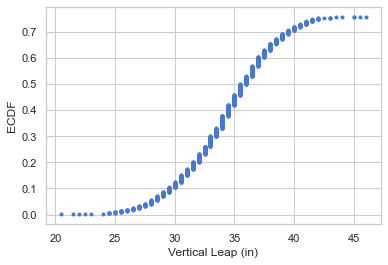

In [31]:
x_vert, y_vert = ecdf(draft_df['Vert Leap (in)'])

_ = plt.plot(x_vert, y_vert, marker='.', linestyle='none')

_ = plt.xlabel('Vertical Leap (in)')
_ = plt.ylabel('ECDF')

In [32]:
for i in range(len(draft_df)):
    if draft_df.iloc[i, 26] == 'D' and np.isnan(draft_df.iloc[i, 8]):
        draft_df.iloc[i, 8] = np.mean(drafted['Vert Leap (in)'])
    elif draft_df.iloc[i, 26] == 'U' and np.isnan(draft_df.iloc[i, 8]):
        draft_df.iloc[i, 8] = np.mean(undrafted['Vert Leap (in)'])

In [33]:
#draft_df['PermutationVert'] = np.random.permutation(draft_df['Vert Leap (in)'])

#draft_df.groupby(by='Drafted')['PermutationVert'].describe()

In [34]:
diffVert = []

for i in range(10000):
    perm_vert = np.random.permutation(draft_df['Vert Leap (in)'])
    mean_vert_diff = np.mean(perm_vert[draft_df['Drafted'] == 'D']) - np.mean(perm_vert[draft_df['Drafted'] == 'U'])
    diffVert.append(mean_vert_diff)

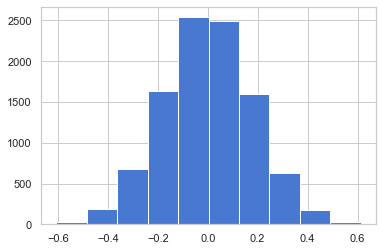

In [35]:
_ = plt.hist(diffVert)

In [36]:
obs_vert_diff = np.mean(draft_df[draft_df['Drafted'] == 'D'])['Vert Leap (in)'] - np.mean(draft_df[draft_df['Drafted'] == 'U'])['Vert Leap (in)']

obs_vert_diff = abs(obs_vert_diff)

print(obs_vert_diff)

1.096651275940971


In [37]:
pos_extreme_vert = []
neg_extreme_vert = []

for j in range(len(diffVert)):
    if(diffVert[j] >= obs_vert_diff):
        pos_extreme_vert.append(diffVert[j])
    elif(diffVert[j] <= -obs_vert_diff):
        neg_extreme_vert.append(diffVert[j])
print(len(pos_extreme_vert))
print(len(neg_extreme_vert))

0
0


Lower than 5% reject null hypothesis

# Exploring Broad Jump

In [38]:
draft_df.groupby(by='Drafted')['Broad Jump (in)'].describe()

,count,mean,std,min,25%,50%,75%,max
Drafted,,,,,,,,
D,863.0,116.026651,8.061566,90.0,111.0,116.0,122.0,136.0
U,372.0,113.844086,6.873316,86.0,109.0,115.0,118.0,133.0


In [39]:
broad_jump_mean = round(np.mean(draft_df['Broad Jump (in)']), 3)
broad_jump_std = round(np.std(draft_df['Broad Jump (in)']), 3)
broad_jump_mean, broad_jump_std

(115.369, 7.782)

C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


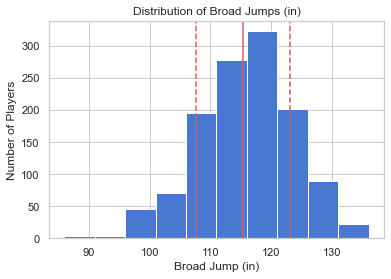

In [40]:
_ = plt.hist(draft_df['Broad Jump (in)'])
_ = plt.xlabel('Broad Jump (in)')
_ = plt.ylabel('Number of Players')
_ = plt.title('Distribution of Broad Jumps (in)')
_ = plt.axvline(broad_jump_mean, color='r')
_ = plt.axvline(broad_jump_mean + broad_jump_std, color='r', linestyle='--')
_ = plt.axvline(broad_jump_mean - broad_jump_std, color='r', linestyle='--')

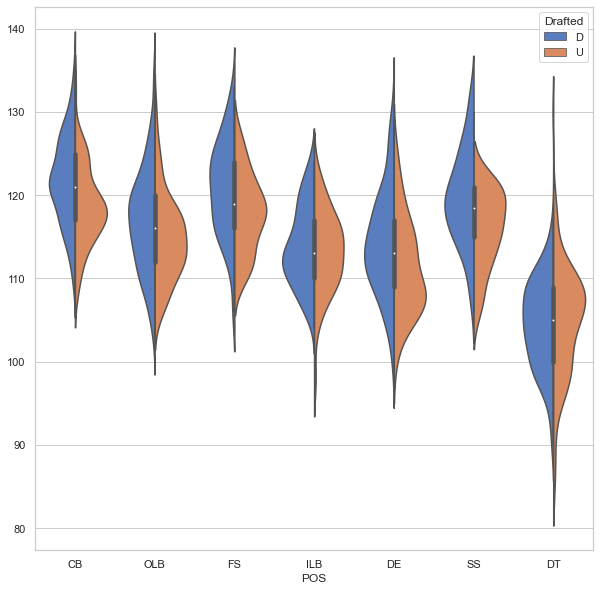

In [41]:
sns.set_theme(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
plt.figure(figsize=(10,10))
ax = sns.violinplot(data=draft_df, x="POS", y="Broad Jump (in)", hue="Drafted", split=True)
_ = ax.set(ylabel="")

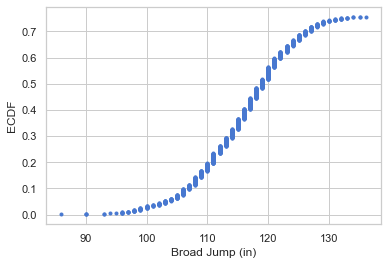

In [42]:
x_broad, y_broad = ecdf(draft_df['Broad Jump (in)'])

_ = plt.plot(x_broad, y_broad, marker='.', linestyle='none')

_ = plt.xlabel('Broad Jump (in)')
_ = plt.ylabel('ECDF')

In [43]:
for i in range(len(draft_df)):
    if draft_df.iloc[i, 26] == 'D' and np.isnan(draft_df.iloc[i, 9]):
        draft_df.iloc[i, 9] = np.mean(drafted['Broad Jump (in)'])
    elif draft_df.iloc[i, 26] == 'U' and np.isnan(draft_df.iloc[i, 9]):
        draft_df.iloc[i, 9] = np.mean(undrafted['Broad Jump (in)'])

In [44]:
#draft_df['PermutationBroad'] = np.random.permutation(draft_df['Broad Jump (in)'])

#draft_df.groupby(by='Drafted')['PermutationBroad'].describe()

In [45]:
diffBroad = []

for i in range(10000):
    perm_broad = np.random.permutation(draft_df['Broad Jump (in)'])
    mean_broad_diff = np.mean(perm_broad[draft_df['Drafted'] == 'D']) - np.mean(perm_broad[draft_df['Drafted'] == 'U'])
    diffBroad.append(mean_broad_diff)

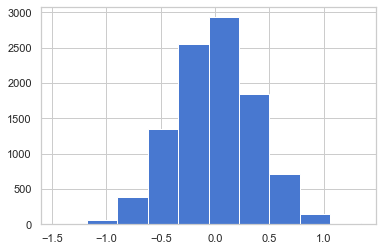

In [46]:
_ = plt.hist(diffBroad)

In [47]:
obs_broad_diff = np.mean(draft_df[draft_df['Drafted'] == 'D'])['Broad Jump (in)'] - np.mean(draft_df[draft_df['Drafted'] == 'U'])['Broad Jump (in)']

obs_broad_dff = abs(obs_broad_diff)

print(obs_broad_diff)

2.1825651951805582


In [48]:
pos_extreme_broad = []
neg_extreme_broad = []

for j in range(len(diffBroad)):
    if(diffBroad[j] >= obs_broad_diff):
        pos_extreme_broad.append(diffBroad[j])
    elif(diffBroad[j] <= -obs_broad_diff):
        neg_extreme_broad.append(diffBroad[j])
print(len(pos_extreme_broad))
print(len(neg_extreme_broad))

0
0


Lower than 5% reject null hypothesis

# Exploring Shuttle Run

In [49]:
draft_df.groupby(by='Drafted')['Shuttle'].describe()

,count,mean,std,min,25%,50%,75%,max
Drafted,,,,,,,,
D,728.0,4.304478,0.236219,3.75,4.14,4.28,4.4400,5.06
U,310.0,4.363097,0.232232,3.86,4.19,4.34,4.5175,4.97


In [50]:
shuttle_mean = round(np.mean(draft_df['Shuttle']), 3)
shuttle_std = round(np.std(draft_df['Shuttle']), 3)
shuttle_mean, shuttle_std

(4.322, 0.236)

C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


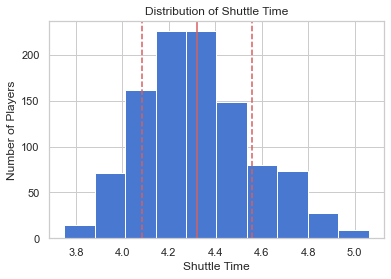

In [51]:
_ = plt.hist(draft_df['Shuttle'])
_ = plt.xlabel('Shuttle Time')
_ = plt.ylabel('Number of Players')
_ = plt.title('Distribution of Shuttle Time')
_ = plt.axvline(shuttle_mean, color='r')
_ = plt.axvline(shuttle_mean + shuttle_std, color='r', linestyle='--')
_ = plt.axvline(shuttle_mean - shuttle_std, color='r', linestyle='--')

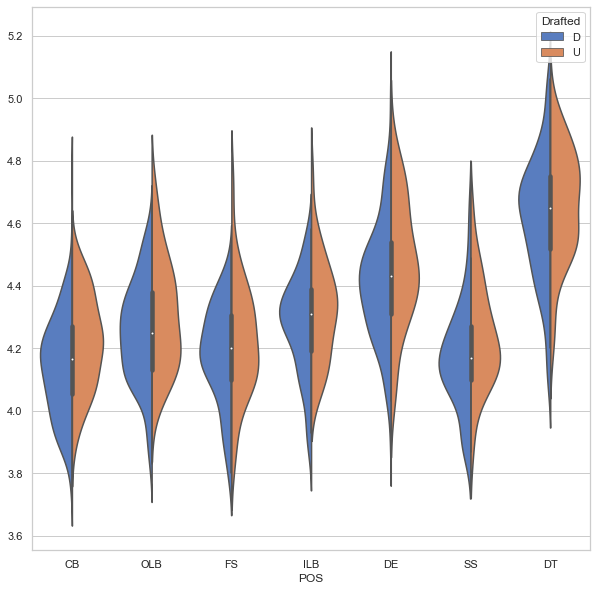

In [52]:
sns.set_theme(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
plt.figure(figsize=(10,10))
ax = sns.violinplot(data=draft_df, x="POS", y="Shuttle", hue="Drafted", split=True)
_ = ax.set(ylabel="")

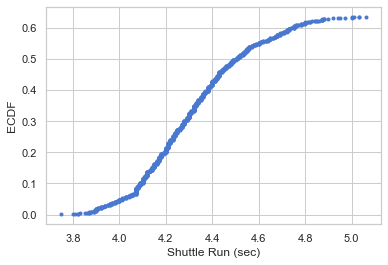

In [53]:
x_shuttle, y_shuttle = ecdf(draft_df['Shuttle'])

_ = plt.plot(x_shuttle, y_shuttle, marker='.', linestyle='none')

_ = plt.xlabel('Shuttle Run (sec)')
_ = plt.ylabel('ECDF')

In [54]:
for i in range(len(draft_df)):
    if draft_df.iloc[i, 26] == 'D' and np.isnan(draft_df.iloc[i, 10]):
        draft_df.iloc[i, 10] = np.mean(drafted['Shuttle'])
    elif draft_df.iloc[i, 26] == 'U' and np.isnan(draft_df.iloc[i, 10]):
        draft_df.iloc[i, 10] = np.mean(undrafted['Shuttle'])

In [55]:
#draft_df['PermutationShuttle'] = np.random.permutation(draft_df['Shuttle'])

#draft_df.groupby(by='Drafted')['PermutationShuttle'].describe()

In [56]:
diffShuttle = []

for i in range(10000):
    perm_shuttle = np.random.permutation(draft_df['Shuttle'])
    mean_shuttle_diff = np.mean(perm_shuttle[draft_df['Drafted'] == 'D']) - np.mean(perm_shuttle[draft_df['Drafted'] == 'U'])
    diffShuttle.append(mean_shuttle_diff)

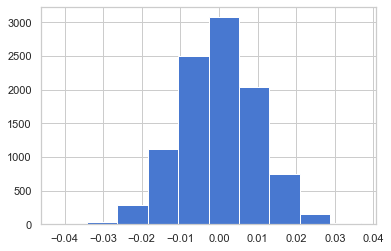

In [57]:
_ = plt.hist(diffShuttle)

In [58]:
obs_shuttle_diff = np.mean(draft_df[draft_df['Drafted'] == 'D'])['Shuttle'] - np.mean(draft_df[draft_df['Drafted'] == 'U'])["Shuttle"]

obs_shuttle_diff = abs(obs_shuttle_diff)

print(obs_shuttle_diff)

0.0586187522155468


In [59]:
pos_extreme_shuttle = []
neg_extreme_shuttle = []

for j in range(len(diffShuttle)):
    if(diffShuttle[j] >= obs_shuttle_diff):
        pos_extreme_shuttle.append(diffShuttle[j])
    elif(diffShuttle[j] <= -obs_shuttle_diff):
        neg_extreme_shuttle.append(diffShuttle[j])
print(len(pos_extreme_shuttle))
print(len(neg_extreme_shuttle))

0
0


Lower than 5% reject null hypothesis

# Exploring Three Cone Drill

In [60]:
draft_df.groupby(by='Drafted')['3Cone'].describe()

,count,mean,std,min,25%,50%,75%,max
Drafted,,,,,,,,
D,721.0,7.204716,0.351393,6.48,6.95,7.15,7.42,8.28
U,309.0,7.308123,0.361512,6.34,7.06,7.27,7.51,8.75


In [61]:
cone3_mean = round(np.mean(draft_df['3Cone']), 3)
cone3_std = round(np.std(draft_df['3Cone']), 3)
cone3_mean, cone3_std

(7.236, 0.357)

C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\vtkurt13\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


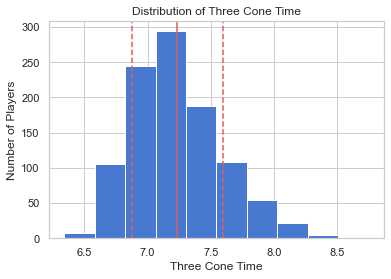

In [62]:
_ = plt.hist(draft_df['3Cone'])
_ = plt.xlabel('Three Cone Time')
_ = plt.ylabel('Number of Players')
_ = plt.title('Distribution of Three Cone Time')
_ = plt.axvline(cone3_mean, color='r')
_ = plt.axvline(cone3_mean + cone3_std, color='r', linestyle='--')
_ = plt.axvline(cone3_mean - cone3_std, color='r', linestyle='--')

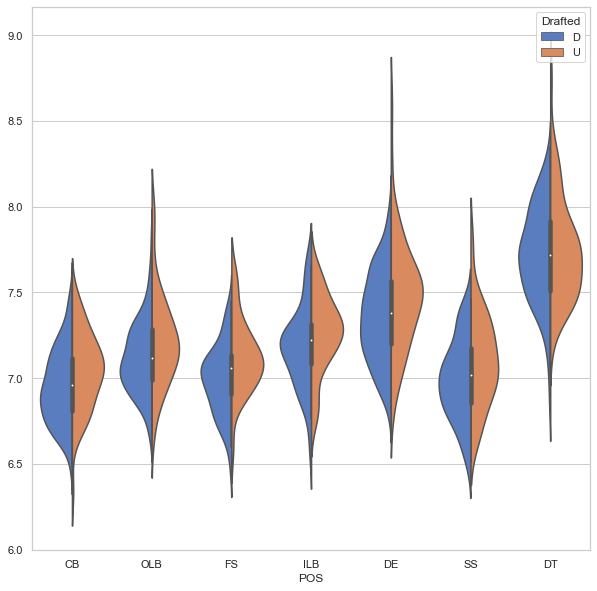

In [63]:
sns.set_theme(style="whitegrid", palette="muted")

# Draw a categorical scatterplot to show each observation
plt.figure(figsize=(10,10))
ax = sns.violinplot(data=draft_df, x="POS", y="3Cone", hue="Drafted", split=True)
_ = ax.set(ylabel="")

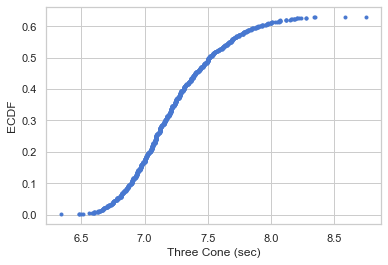

In [64]:
x_cone, y_cone = ecdf(draft_df['3Cone'])

_ = plt.plot(x_cone, y_cone, marker='.', linestyle='none')

_ = plt.xlabel('Three Cone (sec)')
_ = plt.ylabel('ECDF')

In [65]:
for i in range(len(draft_df)):
    if draft_df.iloc[i, 26] == 'D' and np.isnan(draft_df.iloc[i, 11]):
        draft_df.iloc[i, 11] = np.mean(drafted['3Cone'])
    elif draft_df.iloc[i, 26] == 'U' and np.isnan(draft_df.iloc[i, 11]):
        draft_df.iloc[i, 11] = np.mean(undrafted['3Cone'])

In [66]:
#draft_df['PermutationCone'] = np.random.permutation(draft_df['3Cone'])

#draft_df.groupby(by='Drafted')['PermutationCone'].describe()

In [67]:
diffCone = []

for i in range(10000):
    perm_cone = np.random.permutation(draft_df['3Cone'])
    mean_cone_diff = np.mean(perm_cone[draft_df['Drafted'] == 'D']) - np.mean(perm_cone[draft_df['Drafted'] == 'U'])
    diffCone.append(mean_cone_diff)

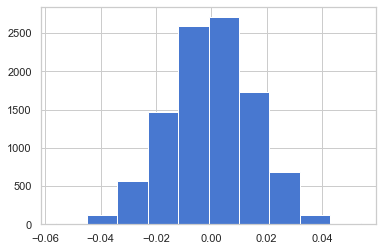

In [68]:
_ = plt.hist(diffCone)

In [69]:
obs_cone_diff = np.mean(draft_df[draft_df['Drafted'] == 'D'])['3Cone'] - np.mean(draft_df[draft_df['Drafted'] == 'U'])['3Cone']

obs_cone_diff = abs(obs_cone_diff)

print(obs_cone_diff)

0.10340730466945036


In [70]:
pos_extreme_cone = []
neg_extreme_cone = []

for j in range(len(diffCone)):
    if(diffCone[j] >= obs_cone_diff):
        pos_extreme_cone.append(diffCone[j])
    elif(diffCone[j] <= -obs_cone_diff):
        neg_extreme_cone.append(diffCone[j])
print(len(pos_extreme_cone))
print(len(neg_extreme_cone))

0
0


Lower than 5% reject the null hypothesis

In [71]:
drafted['Solos_Per_Year'] = 0
drafted['Ints_Per_Year'] = 0
drafted['Sacks_Per_Year'] = 0
drafted['Solos_Per_Game'] = 0

drafted['To'].replace(np.nan, 2006.0, inplace=True)
drafted['Broad Jump (in)'].replace(np.nan, np.mean(drafted['Broad Jump (in)']), inplace=True)
drafted['Solo'].replace(np.nan, 0, inplace=True)
drafted['Solos_Per_Year'].replace(np.nan, np.mean(drafted['Solos_Per_Year']), inplace=True)
drafted['Bench Press'].replace(np.nan, np.mean(drafted['Bench Press']), inplace=True)
drafted['40 Yard'].replace(np.nan, np.mean(drafted['40 Yard']), inplace=True)
drafted['Vert Leap (in)'].replace(np.nan, np.mean(drafted['Vert Leap (in)']), inplace=True)
drafted['Shuttle'].replace(np.nan, np.mean(drafted['Shuttle']), inplace=True)
drafted['3Cone'].replace(np.nan, np.mean(drafted['3Cone']), inplace=True)
drafted['Int'].replace(np.nan, 0, inplace=True)
drafted['Ints_Per_Year'].replace(np.nan, 0, inplace=True)
drafted['Sacks'].replace(np.nan, 0, inplace=True)
drafted['Sacks_Per_Year'].replace(np.nan, 0, inplace=True)


<ipython-input-71-311bf7215556>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drafted['Solos_Per_Year'] = 0
<ipython-input-71-311bf7215556>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drafted['Ints_Per_Year'] = 0
<ipython-input-71-311bf7215556>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

In [72]:
#Solos Per Year Filler
for i in range(len(drafted)):
    if((drafted.iloc[i, 17] - drafted.iloc[i, 0]) == 0):
        drafted.iloc[i, 27] = round(drafted.iloc[i, 23] / 1)
    else:
        drafted.iloc[i, 27] = round(drafted.iloc[i, 23] / (drafted.iloc[i, 17] - drafted.iloc[i, 0]), 2)


C:\Users\vtkurt13\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [73]:
#Solos Per Game Filler

for i in range(len(drafted)):
    if((drafted.iloc[i, 17] - drafted.iloc[i, 0]) == 0):
        drafted.iloc[i, 30] = round(drafted.iloc[i, 23] / 1)
    else:
        per_year = round(drafted.iloc[i, 23] / (drafted.iloc[i, 17] - drafted.iloc[i, 0]), 2)
        drafted.iloc[i, 30] = per_year / 16

In [74]:
#Ints Per Game Filler

for i in range(len(drafted)):
    if((drafted.iloc[i, 17] - drafted.iloc[i, 0]) == 0):
        drafted.iloc[i, 28] = round(drafted.iloc[i, 24] / 1)
    else:
        drafted.iloc[i, 28] = round(drafted.iloc[i, 24] / (drafted.iloc[i, 17] - drafted.iloc[i, 0]), 2)


In [75]:
#Sacks Per Year Filler

for i in range(len(drafted)):
    if((drafted.iloc[i, 17] - drafted.iloc[i, 0]) == 0):
        drafted.iloc[i, 29] = round(drafted.iloc[i, 25] / 1)
    else:
        drafted.iloc[i, 29] = round(drafted.iloc[i, 25] / (drafted.iloc[i, 17] - drafted.iloc[i, 0]), 2)
drafted

,Year,Name,College,POS,Height (in),Weight (lbs),40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),...,CarAV,DrAV,Solo,Int,Sacks,Drafted,Solos_Per_Year,Ints_Per_Year,Sacks_Per_Year,Solos_Per_Game
0,2000.0,Rashard Anderson,Jackson State (MS),CB,74.40,206.0,4.59,21.378664,34.000000,123.000000,...,7.0,7.0,68.0,1.0,0.0,D,68.00,1.00,0.00,4.250000
2,2000.0,Reggie Austin,Wake Forest,CB,69.40,175.0,4.46,17.000000,35.000000,119.000000,...,2.0,2.0,18.0,2.0,0.0,D,9.00,1.00,0.00,0.562500
3,2000.0,Rashidi Barnes,Colorado,FS,71.60,208.0,4.63,10.000000,35.000000,114.000000,...,1.0,1.0,15.0,0.0,0.0,D,15.00,0.00,0.00,15.000000
4,2000.0,David Barrett,Arkansas,CB,69.90,199.0,4.48,16.000000,37.500000,116.000000,...,31.0,14.0,391.0,18.0,0.5,D,48.88,2.25,0.06,3.055000
5,2000.0,William Bartee,Oklahoma,CB,73.00,192.0,4.43,21.378664,38.500000,124.000000,...,13.0,13.0,212.0,0.0,3.5,D,42.40,0.00,0.70,2.650000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,2010.0,Corey Wootton,Northwestern,DE,78.00,270.0,4.92,20.000000,34.439815,116.026651,...,15.0,13.0,65.0,0.0,12.0,D,16.25,0.00,3.00,1.015625
1629,2010.0,Jason Worilds,Virginia Tech,OLB,73.25,254.0,4.65,24.000000,38.000000,114.000000,...,21.0,21.0,144.0,1.0,25.5,D,36.00,0.25,6.38,2.250000
1630,2010.0,Doug Worthington,Ohio State,DT,77.13,292.0,5.02,19.000000,34.439815,116.026651,...,0.0,NaN,2.0,0.0,0.0,D,0.40,0.00,0.00,0.025000
1631,2010.0,Major Wright,Florida,FS,71.50,206.0,4.44,14.000000,37.500000,119.000000,...,20.0,17.0,244.0,9.0,0.0,D,40.67,1.50,0.00,2.541875


In [76]:
draft_df.corr()

,Year,Height (in),Weight (lbs),40 Yard,Bench Press,Vert Leap (in),Broad Jump (in),Shuttle,3Cone,Round,...,Age,To,AP1,PB,St,CarAV,DrAV,Solo,Int,Sacks
Year,1.000000,-0.034535,-0.006397,-0.030826,0.084440,-0.078377,0.040713,0.139529,-0.052075,0.029770,...,-0.079884,0.664990,0.005308,0.040700,-0.024853,-0.034513,0.013972,-0.069389,0.042360,-0.012750
Height (in),-0.034535,1.000000,0.725332,0.511575,0.443502,-0.287245,-0.311092,0.342701,0.351825,-0.042338,...,0.069034,0.025918,0.034619,0.040426,0.058380,0.097689,0.095226,-0.109041,-0.295840,0.340837
Weight (lbs),-0.006397,0.725332,1.000000,0.784492,0.687069,-0.489168,-0.584571,0.540000,0.568049,-0.039117,...,0.048582,0.055563,0.034275,0.029623,0.064174,0.107352,0.099686,-0.148018,-0.360640,0.256551
40 Yard,-0.030826,0.511575,0.784492,1.000000,0.504331,-0.614513,-0.690263,0.595405,0.622342,0.123896,...,0.028017,-0.016636,-0.030449,-0.062190,-0.031550,-0.000656,-0.017359,-0.199726,-0.356043,0.122593
Bench Press,0.084440,0.443502,0.687069,0.504331,1.000000,-0.302952,-0.381144,0.344104,0.351111,-0.058190,...,0.005978,0.116647,0.010096,0.013358,0.044975,0.090357,0.080236,-0.089266,-0.334767,0.222830
Vert Leap (in),-0.078377,-0.287245,-0.489168,-0.614513,-0.302952,1.000000,0.719252,-0.568226,-0.527630,-0.088982,...,-0.041386,-0.038960,0.041241,0.045912,0.014624,0.009831,0.015860,0.135423,0.199642,-0.054094
Broad Jump (in),0.040713,-0.311092,-0.584571,-0.690263,-0.381144,0.719252,1.000000,-0.573873,-0.602254,-0.121917,...,-0.060187,0.042363,0.028002,0.054293,0.017726,0.008466,0.012287,0.139299,0.245868,-0.016233
Shuttle,0.139529,0.342701,0.540000,0.595405,0.344104,-0.568226,-0.573873,1.000000,0.732164,0.067100,...,0.001451,0.107134,0.031241,0.012546,-0.005028,0.015362,0.011952,-0.152996,-0.203016,0.125513
3Cone,-0.052075,0.351825,0.568049,0.622342,0.351111,-0.527630,-0.602254,0.732164,1.000000,0.090602,...,0.023233,-0.053631,-0.000045,-0.030170,-0.038874,-0.024472,-0.015361,-0.163845,-0.234500,0.033544
Round,0.029770,-0.042338,-0.039117,0.123896,-0.058190,-0.088982,-0.121917,0.067100,0.090602,1.000000,...,0.145021,-0.243438,-0.186050,-0.277173,-0.458351,-0.443600,-0.411452,-0.392197,-0.263587,-0.213127


In [77]:
#sns.pairplot(draft_df)

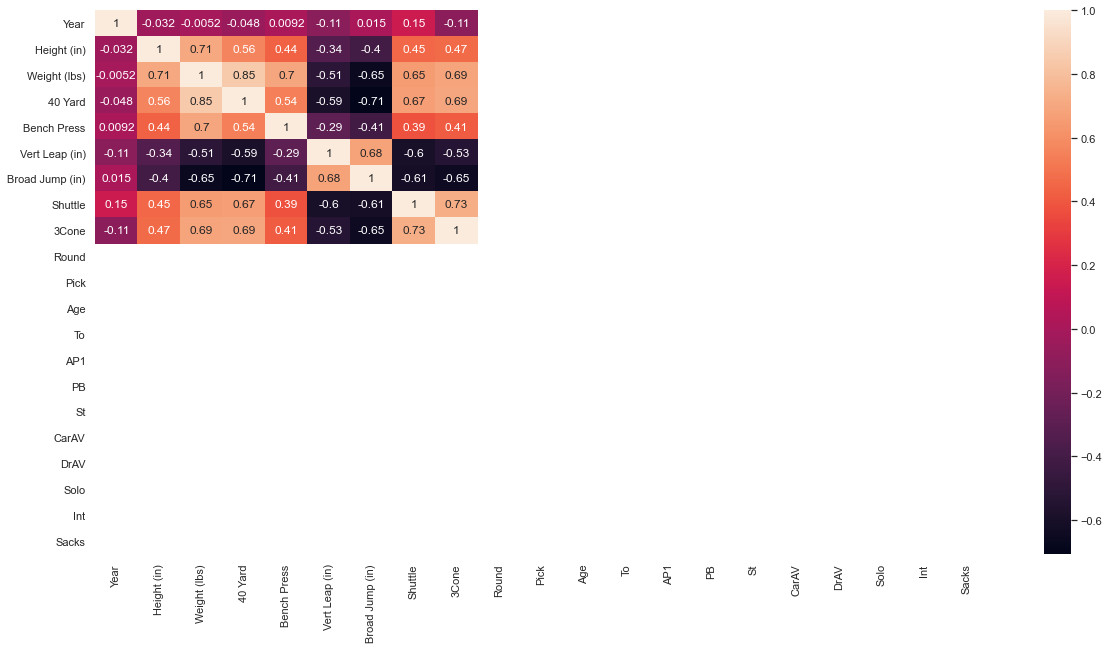

In [78]:
plt.figure(figsize=(20,10))
_ = sns.heatmap(undrafted.corr(), annot=True)

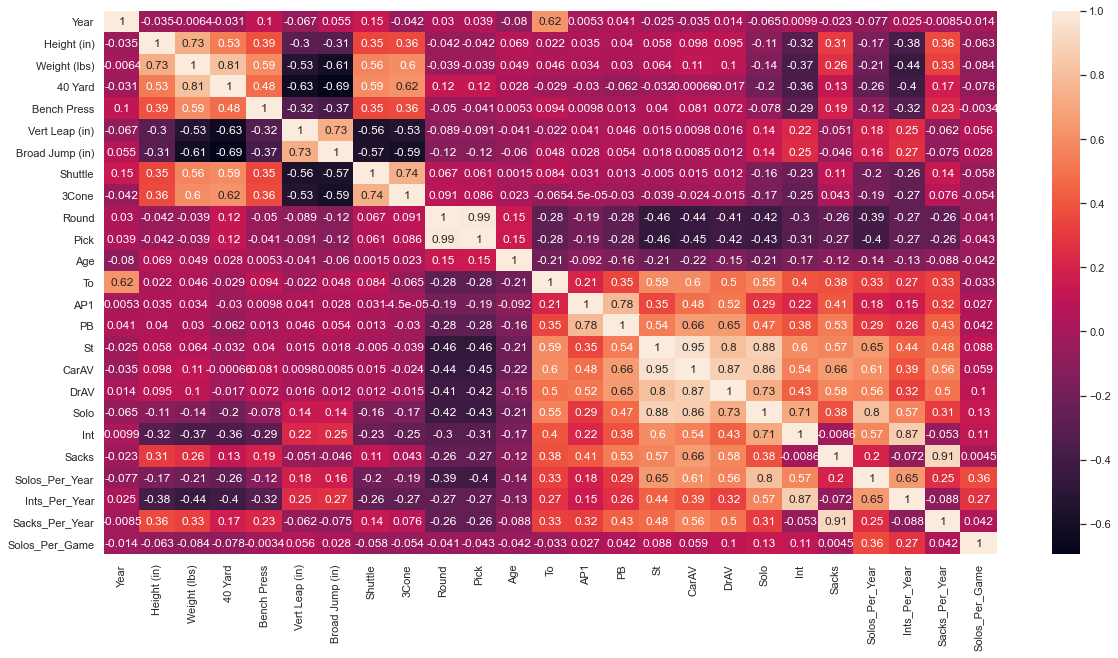

In [79]:
plt.figure(figsize=(20,10))
_ = sns.heatmap(drafted.corr(), annot=True)

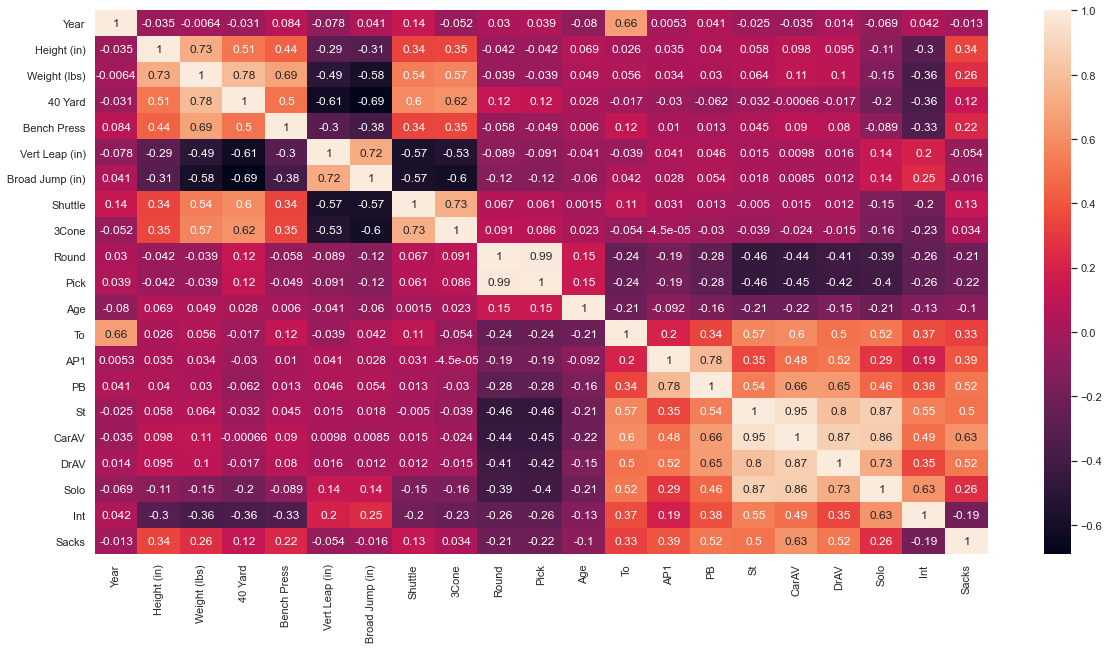

In [90]:
plt.figure(figsize=(20,10))
_ = sns.heatmap(draft_df.corr(), annot=True)

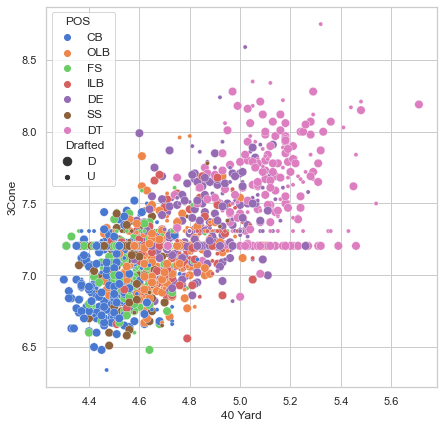

In [80]:
_ = plt.figure(figsize=(7, 7))
_ = sns.scatterplot(x='40 Yard', y='3Cone', data=draft_df, hue='POS', size='Drafted')

In [81]:
y = drafted[['Solos_Per_Year']]
#X = drafted.drop(columns=['Win-Loss Record', 'Solo', 'Round', 'Pick', 'Year', 'Drafted', 'DrAV', 'CarAV', 'AP1', 'Name', 'College', 'POS', 'To', 'Age', 'Team'])
X = drafted[['Height (in)', 'Weight (lbs)','40 Yard', 'Bench Press', 'Vert Leap (in)', 'Broad Jump (in)', 'Shuttle', '3Cone']]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25)


In [82]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(841, 8)
(281, 8)
(841, 1)
(281, 1)


In [83]:
rModel = linear_model.LinearRegression(normalize=True)

In [84]:
rModel.fit(X_train, y_train)

LinearRegression(normalize=True)

In [85]:
rModel.score(X_train, y_train)

0.06050345860732953

In [86]:
rModel.coef_

array([[-1.94612057e-01, -4.21046525e-04, -2.02799757e+01,
         2.39263487e-01,  4.70003794e-01, -2.92889245e-01,
        -8.96152320e+00, -5.26622959e-02]])

In [87]:
pred = rModel.predict(X_test)

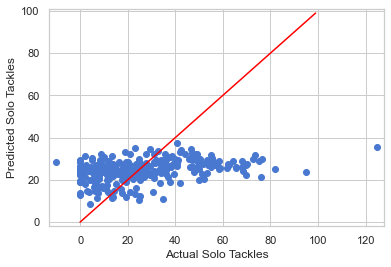

In [88]:
_ = plt.scatter(y_test, pred)
_ = plt.plot([x for x in range(0,100)],[x for x in range(0,100)], color='red')
_ = plt.margins(0.02)
_ = plt.xlabel('Actual Solo Tackles')
_ = plt.ylabel('Predicted Solo Tackles')

In [89]:
drafted.to_csv(r'C:\Users\vtkurt13\Springboard\CapstoneTwoKurstedt\drafted.csv', index=False, header=True)
undrafted.to_csv(r'C:\Users\vtkurt13\Springboard\CapstoneTwoKurstedt\undrafted.csv', index=False, header=True)